In [1]:
import pandas as pd
import numpy as np
import scipy
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import statsmodels.api as sm

warnings.filterwarnings('ignore')

import plotly.express as px
import plotly.offline as py
py.init_notebook_mode(connected=True)
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
from sklearn.utils import shuffle
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import optuna
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
import json
import joblib

# Setting the working directory
# os.chdir(r'../')
if os.getcwd().endswith('notebook'):
    os.chdir(r'../')
print('current working directory:', os.getcwd())

# Pandas option:
pd.set_option('max_colwidth',40)  # This allows us to see the data upto 40 characters per each column

pd.options.display.max_columns = None   # This allows us to see all the columns without collapsing 


# The below code is for for showing all expressions, not just the result of the last expression
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Table styles, this below code is for decorating the dataframe no functional use.
table_styles = {
        'cerulean_palette' : [
        dict(selector="th", props=[("color", "#FFFFFF"), ("background", "#004D80"), ("text-transform", "capitalize")]),
        dict(selector="td", props=[("color", "#333333")]),
        dict(selector="table", props=[("font-family", 'Arial'), ("border-collapse", "collapse")]),
        dict(selector='tr:nth-child(even)', props=[('background', '#D3EEFF')]),
        dict(selector='tr:nth-child(odd)', props=[('background', '#FFFFFF')]),
        dict(selector="th", props=[("border", "1px solid #0070BA")]),
        dict(selector="td", props=[("border", "1px solid #0070BA")]),
        dict(selector="tr:hover", props=[("background", "#80D0FF")])
    ]
}

current working directory: /Users/howechen/Project/ntu_sd6101/ntu_sd6101_team_project


In [49]:
raw_data = pd.read_csv('../ntu_sd6101_team_project_data/zomato.csv', na_values=['-','',' ','NEW','[]'])
raw_data['id'] = raw_data.index

authors = ['cyh','psq','czx','xjl']
marked_data = pd.DataFrame()
for author in authors:
    file_path = f'../ntu_sd6101_team_project_data/subset_{author}/zomato_subset_{author}_labeled_10p.csv'
    marked_df = pd.read_csv(file_path)
    marked_df.rename(columns={'Unnamed: 0':'id'}, inplace=True)
    if 'id' not in marked_df.columns:
        with open(f'../ntu_sd6101_team_project_data/subset_{author}/indexes_{author}.json', 'r') as f:
            ids = json.load(f)
        marked_df['id'] = ids
        f.close()
        # reorder the columns
        original_cols = marked_df.columns.tolist()
        original_cols.remove('id')
        new_cols = ['id'] + original_cols
        marked_df = marked_df[new_cols]
    if 'to_go' in marked_df.columns:
        marked_df.drop(columns=['to_go'], inplace=True)
    # rename the columns
    persons = marked_df.columns.tolist()[-10:]
    # print(persons)
    rename_dict = {}
    for i in range(0, 10):
        rename_dict.update({persons[i]: f'person_{i+1}'})
    marked_df.rename(columns=rename_dict, inplace=True)
    print(marked_df.shape)
    print(marked_df.columns)
    marked_data = pd.concat([marked_data, marked_df], ignore_index=True)
    
location_df = pd.read_csv('../ntu_sd6101_team_project_data/location_info.csv')

(1000, 28)
Index(['id', 'url', 'address', 'name', 'online_order', 'book_table', 'rate',
       'votes', 'phone', 'location', 'rest_type', 'dish_liked', 'cuisines',
       'approx_cost(for two people)', 'reviews_list', 'menu_item',
       'listed_in(type)', 'listed_in(city)', 'person_1', 'person_2',
       'person_3', 'person_4', 'person_5', 'person_6', 'person_7', 'person_8',
       'person_9', 'person_10'],
      dtype='object')
(1000, 28)
Index(['id', 'url', 'address', 'name', 'online_order', 'book_table', 'rate',
       'votes', 'phone', 'location', 'rest_type', 'dish_liked', 'cuisines',
       'approx_cost(for two people)', 'reviews_list', 'menu_item',
       'listed_in(type)', 'listed_in(city)', 'person_1', 'person_2',
       'person_3', 'person_4', 'person_5', 'person_6', 'person_7', 'person_8',
       'person_9', 'person_10'],
      dtype='object')
(1000, 28)
Index(['id', 'url', 'address', 'name', 'online_order', 'book_table', 'rate',
       'votes', 'phone', 'location', 'rest_t

In [141]:
raw_data.shape

(51717, 18)

In [103]:
d1 = pd.read_csv('../ntu_sd6101_team_project_data/task1_data/original_data_with_prediction.csv')
d2 = pd.read_csv('../ntu_sd6101_team_project_data/task1_data/new_data_with_predictions.csv')
d3 = pd.read_csv('../ntu_sd6101_team_project_data/task1_data/neated_ratings_need_mark_final11.csv')
d4 = pd.read_csv('../ntu_sd6101_team_project_data/task1_data/final_zomato_restaurants11.csv')
d5 = pd.read_csv('../ntu_sd6101_team_project_data/task1_data/neated_final_zomato_restaurants11.csv')
d6 = pd.read_csv('../ntu_sd6101_team_project_data/task1_data/ratings_need_mark11.csv')
d7 = pd.read_csv('../ntu_sd6101_team_project_data/task1_data/task1_training_samples_features_display.csv')
d8 = pd.read_csv('../ntu_sd6101_team_project_data/task1_data/task1_negative_samples_features_display.csv')

d1.shape, d2.shape, d3.shape, d4.shape, d5.shape, d6.shape, d7.shape, d8.shape

((23202, 14),
 (23202, 78),
 (23202, 77),
 (28288, 13),
 (28288, 77),
 (23202, 13),
 (28621, 120),
 (23096, 120))

final -> training
- selected attributes -> raw: shape:(28288, 13)
- neated -> features: shape(28288, 77)

need mark -> negative
- selected attributes -> raw: shape:(28288, 13)
- neated -> features: shape:(23202, 77)
- prediction
    - raw_with_results: shape:(28288, 14)
    - features_with_results: shape:(23202, 78)

In [104]:
d3.shape[0] + d4.shape[0], d7.shape[0]+d8.shape[0], raw_data.shape[0]

(51490, 51717, 51717)

In [39]:
raw_data.head()

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city),id
0,https://www.zomato.com/bangalore/jal...,"942, 21st Main Road, 2nd Stage, Bana...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, P...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful...",NaN,Buffet,Banashankari,0
1,https://www.zomato.com/bangalore/spi...,"2nd Floor, 80 Feet Road, Near Big Ba...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirva...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been he...",NaN,Buffet,Banashankari,1
2,https://www.zomato.com/SanchurroBang...,"1112, Next to KIMS Medical College, ...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is...",NaN,Buffet,Banashankari,2
3,https://www.zomato.com/bangalore/add...,"1st Floor, Annakuteera, 3rd Stage, B...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food ...",NaN,Buffet,Banashankari,3
4,https://www.zomato.com/bangalore/gra...,"10, 3rd Floor, Lakshmi Associates, G...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good r...",NaN,Buffet,Banashankari,4


In [51]:
def func1(string):
    l=string.split(", ")
    
    if "Afghan" in l:
        l=list(map(lambda x: x.replace('Afghan', 'Afghani'), l))
        
    if "Bubble Tea" in l:
        l=list(map(lambda x: x.replace('Bubble Tea', 'Beverages'), l))
        
    if "Coffee" in l:
        l=list(map(lambda x: x.replace('Coffee', 'Beverages'), l))
        
    if "Cafe" in l:
        l=list(map(lambda x: x.replace('Cafe', 'Beverages'), l))
       
    if "Tea" in l:
        l=list(map(lambda x: x.replace('Tea', 'Beverages'), l))
        
    if "Bubble Beverages" in l:
        l=list(map(lambda x: x.replace('Bubble Beverages', 'Beverages'), l))
       
    if "Ice Cream" in l:
        l=list(map(lambda x: x.replace('Ice Cream', 'Desserts'), l))
        
    if "Mithai" in l:
        l=list(map(lambda x: x.replace('Mithai', 'Desserts'), l))
      
    if "Bar Food" in l:
        l=list(map(lambda x: x.replace('Bar Food', 'Fast Food'), l))
        
    if "Burger" in l:
        l=list(map(lambda x: x.replace('Burger', 'Fast Food'), l))
       
    if "Finger Food" in l:
        l=list(map(lambda x: x.replace('Finger Food', 'Fast Food'), l))
        
    if "Momos" in l:
        l=list(map(lambda x: x.replace('Momos', 'Fast Food'), l))
        
    if "Rolls" in l:
        l=list(map(lambda x: x.replace('Rolls', 'Fast Food'), l))
    
    if "Wraps" in l:
        l=list(map(lambda x: x.replace('Wraps', 'Fast Food'), l))
        
    if "Street Food" in l:
        l=list(map(lambda x: x.replace('Street Food', 'Fast Food'), l))
 
    if "Juices" in l:
        l=list(map(lambda x: x.replace('Juices', 'Healthy Food'), l))
       
    if "Salad" in l:
        l=list(map(lambda x: x.replace('Salad', 'Healthy Food'), l))
     
    if "Sandwich" in l:
        l=list(map(lambda x: x.replace('Sandwich', 'Healthy Food'), l))
      
    if "Grill" in l:
        l=list(map(lambda x: x.replace('Grill', 'BBQ'), l))
    
    if "Steak" in l:
        l=list(map(lambda x: x.replace('Steak', 'BBQ'), l))
        
    if "Sushi" in l:
        l=list(map(lambda x: x.replace('Sushi', 'Japanese'), l))
        
    if "Tex-Mex" in l:
        l=list(map(lambda x: x.replace('Tex-Mex', 'Mexican'), l))
        
    if "Roast Chicken" in l:
        l=list(map(lambda x: x.replace('Roast Chicken', 'Chinese'), l))
        
    if "Charcoal Chicken" in l:
        l=list(map(lambda x: x.replace('Charcoal Chicken', 'Chinese'), l))
        
    if "Pizza" in l:
        l=list(map(lambda x: x.replace('Pizza', 'Italian'), l))
        
    if "Biryani" in l:
        l=list(map(lambda x: x.replace('Biryani', 'South Indian'), l))
        
    if "Kebab" in l:
        l=list(map(lambda x: x.replace('Kebab', 'North Indian'), l))
    
    return ", ".join(set(l))

In [52]:
def process_features(input_df):
    sample_df = input_df.copy()
    df = sample_df.drop([ 'url','phone','reviews_list','rest_type'],axis=1)

    df['cuisines'].fillna('Other', inplace=True)
    df["cuisines"] = df["cuisines"].apply(lambda x: func1(str(x)))
    df['votes'] = df['votes'].astype('int')
    df['approx_cost(for two people)'] = df['approx_cost(for two people)'].str.replace(",","").astype(float)
    df[-df['rate'].isna()]['rate'] = df[-df['rate'].isna()]['rate'].str.replace("/5","").astype(float)
    col = ["listed_in(city)","listed_in(type)"]
    ser = df.groupby(col)['approx_cost(for two people)'].transform('median')
    df['approx_cost(for two people)'] = df['approx_cost(for two people)'].fillna(ser)
    df['Cost_Per_Person'] = df['approx_cost(for two people)']/2
    df.drop(columns='approx_cost(for two people)', inplace=True)

    def p_category(price):
        if price<=100.0:
            return "Cheap"
        elif price<=250.0:
            return "Resonable"
        elif price<=500.0:
            return "Affordable"
        else:
            return "Expensive"

    df["rate"] = df["rate"].str[0:3].astype(float)
    df["Price_Category"] = df["Cost_Per_Person"].apply(p_category)

    # whether menu is available or not

    df['menu_item'].fillna('No',inplace=True)
    df["Menu"] = df["menu_item"].map(lambda x: "Yes" if x != 'No' else "No")

    #no of dishes liked by customer at a restaurant
    df[df['dish_liked'].isnull()]['dish_liked'] = ''
    df['dish_liked'] = df['dish_liked'].map(lambda x:0 if x=="" else len(str(x).split(", ")))

    # No of varieties served at a restaurant

    df['No_of_Varieties']=df['cuisines'].apply(lambda x:len(str(x).split(", ")))
    change = {'name':'Name',
            'address':'Address',
            'online_order':"Delivery",
            'book_table':"Booking", 
            'rate':"Rating", 
            'dish_liked':"No_of_Best_Sellers",
            'cuisines':"Cuisines", 
            'approx_cost(for two people)':"Average_Cost", 
            'listed_in(type)':"Type",
            'listed_in(city)':"City"}

    df.rename(columns=change,inplace=True)
    df.reset_index(drop=True,inplace=True)

    display_df=df[['id','Name','Address','Menu','Delivery', 'Booking', 'No_of_Best_Sellers', 'No_of_Varieties', 'Cuisines',
        'Cost_Per_Person', 'Type', 'City', 'Rating','Price_Category']]

    multi_label = display_df["Cuisines"].str.split(", ")
    mlb = MultiLabelBinarizer()
    inter_data = mlb.fit_transform(multi_label)
    multi_label_df = pd.DataFrame(inter_data,columns=mlb.classes_)
    display = pd.concat([display_df,multi_label_df],axis=1)

    one_hot = display[['Delivery', 'Booking', 'City']]
    numeric = display[['id','No_of_Best_Sellers', 'No_of_Varieties', 'Cost_Per_Person', 'Rating']]

    encoder = OneHotEncoder()
    one_hot_df = pd.DataFrame(encoder.fit_transform(one_hot).toarray(),index=list(display.index))

    df_inter = pd.concat([numeric,multi_label_df.iloc[list(display.index),:],one_hot_df],axis=1)
    df_inter.reset_index(drop=True,inplace=True)
    df_inter.head()

    return df_inter

In [53]:
features_df = process_features(raw_data)
features_df.head()

,id,No_of_Best_Sellers,No_of_Varieties,Cost_Per_Person,Rating,Afghani,African,American,Andhra,Arabian,Asian,Assamese,Australian,Awadhi,BBQ,Bakery,Belgian,Bengali,Beverages,Bihari,Bohri,British,Burmese,Cantonese,Chettinad,Chinese,Continental,Desserts,Drinks Only,European,Fast Food,French,German,Goan,Greek,Gujarati,Healthy Food,Hot dogs,Hyderabadi,Indian,Indonesian,Iranian,Italian,Japanese,Jewish,Kashmiri,Kerala,Konkan,Korean,Lebanese,Lucknowi,Maharashtrian,Malaysian,Malwani,Mangalorean,Mediterranean,Mexican,Middle Eastern,Modern Indian,Mongolian,Mughlai,Naga,Nepalese,North Eastern,North Indian,Oriya,Other,Paan,Pan Asian,Parsi,Portuguese,Rajasthani,Raw Meats,Russian,Seafood,Sindhi,Singaporean,South American,South Indian,Spanish,Sri Lankan,Tamil,Thai,Tibetan,Turkish,Vegan,Vietnamese,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
0,0,7,3,400.0,4.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,7,3,400.0,4.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,7,3,400.0,3.8,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,1,2,150.0,3.7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2,2,300.0,3.8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
marked_data['customer_preference'] = marked_data[['person_1', 'person_2', 'person_3', 'person_4', 'person_5', 'person_6', 'person_7', 'person_8', 'person_9', 'person_10']].mean(axis=1)
marked_data['customer_preference'] = marked_data['customer_preference']/5
marked_data.head()

,id,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city),person_1,person_2,person_3,person_4,person_5,person_6,person_7,person_8,person_9,person_10,customer_preference
0,8440,https://www.zomato.com/bangalore/kal...,"399, 16th Main, N.S Palya, BTM, Bang...",Kalingas,Yes,No,3.9,179,080 42038180,BTM,Quick Bites,"Rasgulla, Mutton Kosha, Chicken Kash...","Oriya, Fast Food",250,"[('Rated 3.0', 'RATED\n A pocket fr...",NaN,Delivery,BTM,4,4,4,4,5,4,4,4,4,5,0.84
1,23575,https://www.zomato.com/bangalore/ang...,"1st Cross, Bilekahalli, Near IIMB Co...",Angel Restaurant,Yes,No,2.8,165,+91 9035699847\r\n+91 9880714970,Bannerghatta Road,Quick Bites,NaN,"Kerala, South Indian, North Indian",450,"[('Rated 1.0', 'RATED\n I cannot sa...","['Kappa', 'Kappa Biryani', 'Chicken ...",Dine-out,JP Nagar,3,3,4,3,3,4,3,3,3,4,0.66
2,16711,https://www.zomato.com/bangalore/caf...,"4rd floor, 7th Cross, Opposite to BM...",Cafe Talkhouse,No,No,3.8,23,NaN,HSR,Quick Bites,NaN,North Indian,NaN,"[('Rated 5.0', 'RATED\n Have been t...",NaN,Delivery,HSR,4,4,4,4,4,4,4,4,4,5,0.82
3,42588,https://www.zomato.com/bangalore/par...,"17/1 Cambridge Road, Opposite The Fr...",Paratha Xpress,No,No,3.5,8,065535 07908402366,Ulsoor,Quick Bites,NaN,"North Indian, Chinese",200,"[('Rated 5.0', 'RATED\n good job!')...",NaN,Delivery,MG Road,4,4,4,4,4,4,4,4,4,5,0.82
4,5266,https://www.zomato.com/bangalore/cla...,"Skywalk, 5/1, Near Body Craft, Assay...",Classic Lassi Shop,Yes,No,3.5,43,+91 8792958786\r\r\n+91 8073579529,Ulsoor,Beverage Shop,NaN,"Beverages, Ice Cream",150,"[('Rated 3.0', 'RATED\n I have mixe...","['Fruit Salad with Ice Cream', 'Brow...",Delivery,Brigade Road,4,4,4,4,4,4,4,4,4,4,0.80


In [47]:
marked_data.shape

(4000, 30)

In [54]:
all_data = pd.merge(raw_data, features_df, on='id', how='left')
all_data = pd.merge(all_data, marked_data[['id', 'customer_preference']], on='id', how='left')
all_data = pd.merge(all_data, location_df, on='location', how='left')
all_data['rate'] = all_data['rate'].apply(lambda x: float(x.split('/')[0]) if type(x) == str else x)
all_data['rate'] = all_data['rate'].fillna(all_data['Rating'].mean())
all_data.head()

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city),id,No_of_Best_Sellers,No_of_Varieties,Cost_Per_Person,Rating,Afghani,African,American,Andhra,Arabian,Asian,Assamese,Australian,Awadhi,BBQ,Bakery,Belgian,Bengali,Beverages,Bihari,Bohri,British,Burmese,Cantonese,Chettinad,Chinese,Continental,Desserts,Drinks Only,European,Fast Food,French,German,Goan,Greek,Gujarati,Healthy Food,Hot dogs,Hyderabadi,Indian,Indonesian,Iranian,Italian,Japanese,Jewish,Kashmiri,Kerala,Konkan,Korean,Lebanese,Lucknowi,Maharashtrian,Malaysian,Malwani,Mangalorean,Mediterranean,Mexican,Middle Eastern,Modern Indian,Mongolian,Mughlai,Naga,Nepalese,North Eastern,North Indian,Oriya,Other,Paan,Pan Asian,Parsi,Portuguese,Rajasthani,Raw Meats,Russian,Seafood,Sindhi,Singaporean,South American,South Indian,Spanish,Sri Lankan,Tamil,Thai,Tibetan,Turkish,Vegan,Vietnamese,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,customer_preference,location_id,restaurant_count,latitude,longitude,northeast_lat,northeast_lng,southwest_lat,southwest_lng,area,area_proportion,area_population,area_customer_flow
0,https://www.zomato.com/bangalore/jal...,"942, 21st Main Road, 2nd Stage, Bana...",Jalsa,Yes,Yes,4.1,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, P...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful...",NaN,Buffet,Banashankari,0,7,3,400.0,4.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,906.0,12.925453,77.546757,12.956544,77.574414,12.912888,77.531272,2.260970e+07,0.002921,1.083382e+06,3164.3497
1,https://www.zomato.com/bangalore/spi...,"2nd Floor, 80 Feet Road, Near Big Ba...",Spice Elephant,Yes,No,4.1,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirva...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been he...",NaN,Buffet,Banashankari,1,7,3,400.0,4.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,906.0,12.925453,77.546757,12.956544,77.574414,12.912888,77.531272,2.260970e+07,0.002921,1.083382e+06,3164.3497
2,https://www.zomato.com/SanchurroBang...,"1112, Next to KIMS Medical College, ...",San Churro Cafe,Yes,No,3.8,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is...",NaN,Buffet,Banashankari,2,7,3,400.0,3.8,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,906.0,12.925453,77.546757,12.956544,77.574414,12.912888,77.531272,2.260970e+07,0.002921,1.083382e+06,3164.3497
3,https://www.zomato.com/bangalore/add...,"1st Floor, Annakuteera, 3rd Stage, B...",Addhuri Udupi Bhojana,No,No,3.7,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food ...",NaN,Buffet,Banashankari,3,1,2,150.0,3.7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [65]:
ht_data = all_data[all_data['id'].isin(marked_data['id'].values.tolist())]
ht_data['restaurant_count'].fillna(ht_data['restaurant_count'].mean(), inplace=True)
ht_data.shape

(4000, 151)

In [66]:
# Model: customer_preference ~ rate
# H0: customer_preference dosen't hava significant relationship with rate
# H1: customer_preference has significant relationship with rate

X1 = ht_data.loc[:,['rate']]
y1 = ht_data['customer_preference']

X1 = sm.add_constant(X1)
glm_model_1 = sm.OLS(y1, X1)
glm_results_1 = glm_model_1.fit()

print(glm_results_1.summary())

                             OLS Regression Results                            
Dep. Variable:     customer_preference   R-squared:                       0.011
Model:                             OLS   Adj. R-squared:                  0.011
Method:                  Least Squares   F-statistic:                     43.89
Date:                 Sat, 09 Nov 2024   Prob (F-statistic):           3.93e-11
Time:                         15:31:15   Log-Likelihood:                 993.46
No. Observations:                 4000   AIC:                            -1983.
Df Residuals:                     3998   BIC:                            -1970.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3831      0.028     13.55

In [67]:
# Model: customer_preference ~ restaurant_count
# H0: customer_preference dosen't hava significant relationship with restaurant_count
# H1: customer_preference has significant relationship with restaurant_count

X1 = ht_data.loc[:,['restaurant_count']]
y1 = ht_data['customer_preference']

X1 = sm.add_constant(X1)
glm_model_1 = sm.OLS(y1, X1)
glm_results_1 = glm_model_1.fit()

print(glm_results_1.summary())

                             OLS Regression Results                            
Dep. Variable:     customer_preference   R-squared:                       0.000
Model:                             OLS   Adj. R-squared:                 -0.000
Method:                  Least Squares   F-statistic:                    0.4467
Date:                 Sat, 09 Nov 2024   Prob (F-statistic):              0.504
Time:                         15:31:17   Log-Likelihood:                 971.85
No. Observations:                 4000   AIC:                            -1940.
Df Residuals:                     3998   BIC:                            -1927.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.5669   

In [68]:
ht_data['log_restaurant_count'] = np.log(ht_data['restaurant_count'])
ht_data['log_cost_per_person'] = np.log(ht_data['Cost_Per_Person'])
ht_data['log_area_customer_flow'] = np.log(ht_data['area_customer_flow'])
ht_data['log_No_of_Best_Sellers'] = np.log(ht_data['No_of_Best_Sellers'])
ht_data['log_No_of_Varieties'] = np.log(ht_data['No_of_Varieties'])

In [69]:
X1 = ht_data.loc[:,['rate', 'log_restaurant_count']]
y1 = ht_data['customer_preference']

X1 = sm.add_constant(X1)
ols_model_1 = sm.OLS(y1, X1)
ols_results_1 = ols_model_1.fit()

print(ols_results_1.summary())

                             OLS Regression Results                            
Dep. Variable:     customer_preference   R-squared:                       0.011
Model:                             OLS   Adj. R-squared:                  0.010
Method:                  Least Squares   F-statistic:                     22.13
Date:                 Sat, 09 Nov 2024   Prob (F-statistic):           2.77e-10
Time:                         15:31:24   Log-Likelihood:                 993.64
No. Observations:                 4000   AIC:                            -1981.
Df Residuals:                     3997   BIC:                            -1962.
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 

In [70]:
robust_model = sm.RLM(y1, X1, M=sm.robust.norms.HuberT())
robust_results = robust_model.fit()

print(robust_results.summary())

                     Robust linear Model Regression Results                    
Dep. Variable:     customer_preference   No. Observations:                 4000
Model:                             RLM   Df Residuals:                     3997
Method:                           IRLS   Df Model:                            2
Norm:                           HuberT                                         
Scale Est.:                        mad                                         
Cov Type:                           H1                                         
Date:                 Sat, 09 Nov 2024                                         
Time:                         15:31:32                                         
No. Iterations:                     34                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 

In [71]:
glm_model = sm.GLM(y1, X1, family=sm.families.Gaussian())
glm_results_1 = glm_model.fit()

print(glm_results_1.summary())

                  Generalized Linear Model Regression Results                  
Dep. Variable:     customer_preference   No. Observations:                 4000
Model:                             GLM   Df Residuals:                     3997
Model Family:                 Gaussian   Df Model:                            2
Link Function:                Identity   Scale:                        0.035652
Method:                           IRLS   Log-Likelihood:                 993.64
Date:                 Sat, 09 Nov 2024   Deviance:                       142.50
Time:                         15:31:34   Pearson chi2:                     143.
No. Iterations:                      3   Pseudo R-squ. (CS):            0.01100
Covariance Type:             nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 

In [72]:
# 1. Function for Coefficient Plot with 95% CI
def plot_coefficient_plot(model_results, X_data):
    conf_int = model_results.conf_int()
    coef_df = pd.DataFrame({
        'coef': model_results.params[1:],  # Exclude constant
        'var': X_data.columns[1:],  # Exclude constant
        'ci_lower': conf_int.iloc[1:, 0],
        'ci_upper': conf_int.iloc[1:, 1]
    })
    plt.errorbar(x=range(len(coef_df)), 
                 y=coef_df['coef'], 
                 yerr=[coef_df['coef'] - coef_df['ci_lower'], coef_df['ci_upper'] - coef_df['coef']], 
                 fmt='o')
    plt.axhline(0, color='red', linestyle='--', linewidth=0.5)
    plt.xticks(range(len(coef_df)), coef_df['var'], rotation=45)
    plt.title('Coefficient Plot with 95% CI')

# 2. Function for Residuals vs Fitted Plot
def plot_residuals_vs_fitted(model_results, X_data, y_data):
    fitted_values = model_results.fittedvalues
    residuals = model_results.resid
    plt.scatter(fitted_values, residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--', linewidth=0.5)
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Fitted')

# 3. Function for Normal Q-Q Plot
def plot_qq_plot(model_results):
    sm.qqplot(model_results.resid, line='45')
    plt.title('Normal Q-Q Plot')

# 4. Function for Residuals Distribution Plot
def plot_residuals_distribution(model_results):
    sns.histplot(model_results.resid, kde=True)
    plt.xlabel('Residuals')
    plt.title('Residuals Distribution')

# 5. Function for Scale-Location Plot
def plot_scale_location(model_results, X_data, y_data):
    fitted_values = model_results.fittedvalues
    standardized_residuals = np.sqrt(np.abs(stats.zscore(model_results.resid)))
    plt.scatter(fitted_values, standardized_residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--', linewidth=0.5)
    plt.xlabel('Fitted Values')
    plt.ylabel(r'Sqrt(|Standardized Residuals|)')
    plt.title('Scale-Location Plot')

# 6. Function for Actual vs Predicted Plot
def plot_actual_vs_predicted(model_results, y_data):
    fitted_values = model_results.fittedvalues
    plt.scatter(y_data, fitted_values, alpha=0.5)
    plt.plot([y_data.min(), y_data.max()], [y_data.min(), y_data.max()], 'r--', lw=0.5)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted')

# Main function to combine all plots
def plot_regression_results(model_results, X_data, y_data, figsize=(15, 10)):
    """
    Visualize regression results with multiple plots
    
    Parameters:
    -----------
    model_results : statsmodels regression results object
    X_data : DataFrame of features
    y_data : Series of target variable
    figsize : tuple, optional (default=(15, 10))
        Figure size
    """
    # Create figure with subplots
    fig = plt.figure(figsize=figsize)
    
    # 1. Coefficient Plot
    plt.subplot(231)
    conf_int = model_results.conf_int()
    coef_df = pd.DataFrame({
        'coef': model_results.params[1:],  # Exclude constant
        'var': X_data.columns[1:],  # Exclude constant
        'ci_lower': conf_int.iloc[1:, 0],
        'ci_upper': conf_int.iloc[1:, 1]
    })
    
    plt.errorbar(x=range(len(coef_df)), 
                y=coef_df['coef'],
                yerr=[coef_df['coef'] - coef_df['ci_lower'], 
                      coef_df['ci_upper'] - coef_df['coef']],
                fmt='o', capsize=5)
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
    plt.xticks(range(len(coef_df)), coef_df['var'], rotation=45)
    plt.title('Coefficient Plot with 95% CI')
    plt.grid(True, alpha=0.3)
    
    # 2. Residuals vs Fitted
    plt.subplot(232)
    fitted_vals = model_results.fittedvalues
    residuals = model_results.resid
    plt.scatter(fitted_vals, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Fitted')
    plt.grid(True, alpha=0.3)
    
    # 3. QQ Plot
    plt.subplot(233)
    fig = stats.probplot(residuals, dist="norm", plot=plt)
    plt.title('Normal Q-Q Plot')
    
    # 4. Residuals Distribution
    plt.subplot(234)
    sns.histplot(residuals, kde=True)
    plt.title('Residuals Distribution')
    plt.xlabel('Residuals')
    
    # 5. Scale-Location Plot
    plt.subplot(235)
    std_resid = residuals / np.std(residuals)
    plt.scatter(fitted_vals, np.sqrt(np.abs(std_resid)), alpha=0.5)
    plt.xlabel('Fitted Values')
    plt.ylabel('Sqrt(|Standardized Residuals|)')
    plt.title('Scale-Location Plot')
    plt.grid(True, alpha=0.3)
    
    # 6. Actual vs Predicted
    plt.subplot(236)
    plt.scatter(y_data, fitted_vals, alpha=0.5)
    min_val = min(min(y_data), min(fitted_vals))
    max_val = max(max(y_data), max(fitted_vals))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.3)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

((array([-3.57776594, -3.33887858, -3.20703053, ...,  3.20703053,
          3.33887858,  3.57776594]),
  array([-0.42399193, -0.41882364, -0.41589564, ...,  0.44503616,
          0.45007085,  0.46049181])),
 (np.float64(0.1823817957161633),
  np.float64(-2.2353002553451026e-16),
  np.float64(0.9654913251527895)))

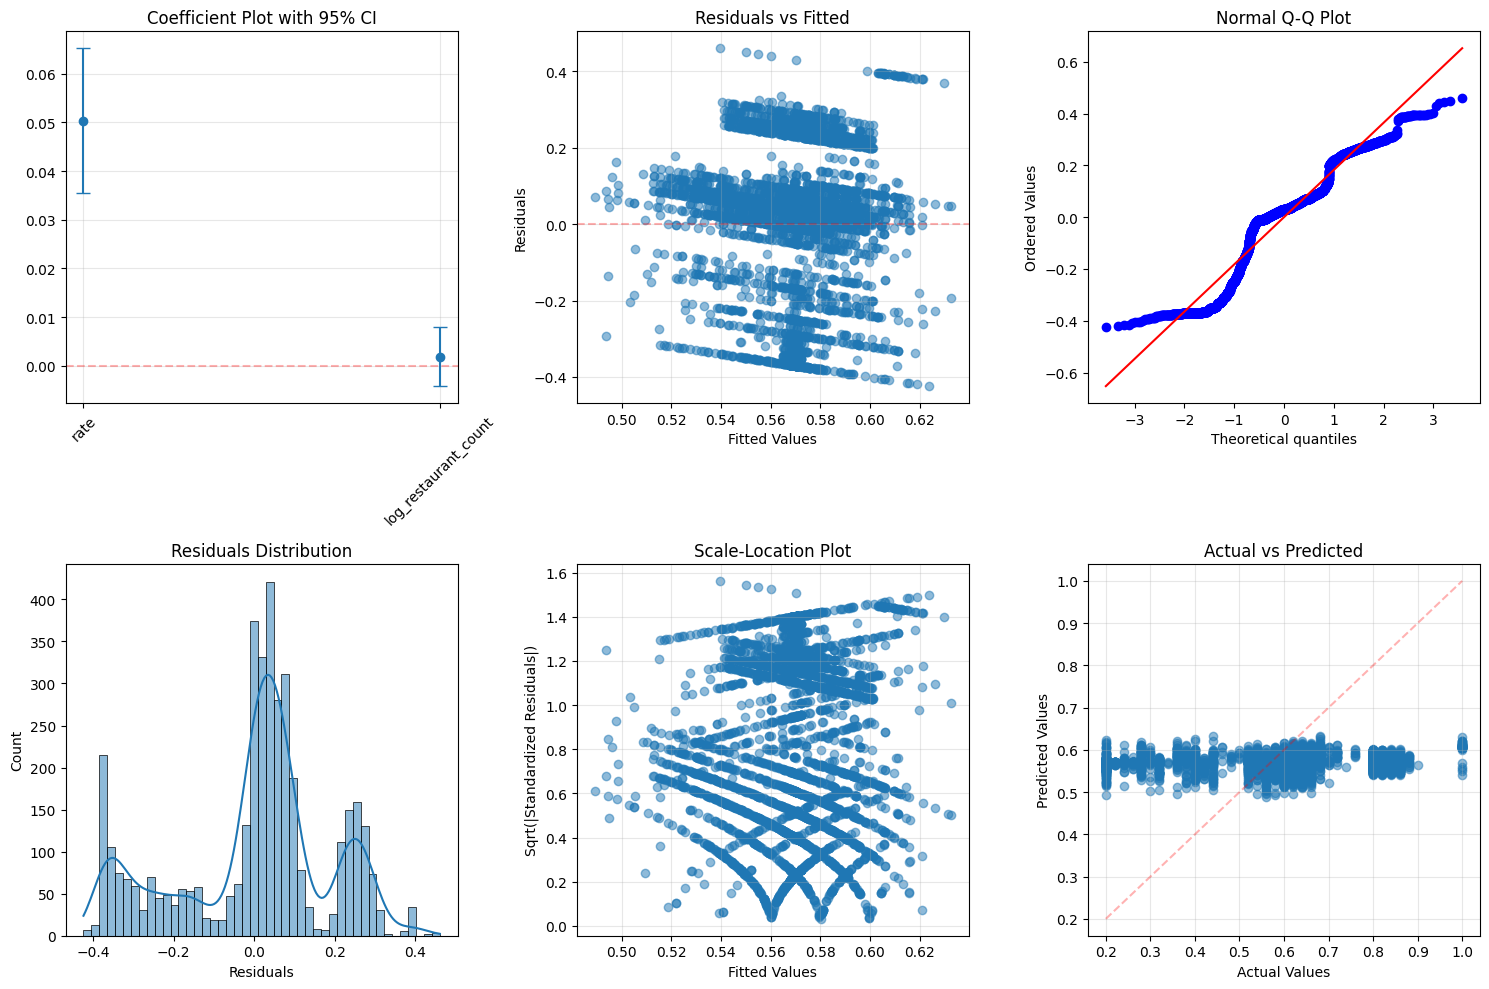

In [73]:
plot_regression_results(ols_results_1, X1, y1)

((array([-3.57776594, -3.33887858, -3.20703053, ...,  3.20703053,
          3.33887858,  3.57776594]),
  array([-0.43939943, -0.43487725, -0.43109155, ...,  0.41999395,
          0.42447221,  0.43072119])),
 (np.float64(0.18230128893872147),
  np.float64(-0.02098286013327522),
  np.float64(0.964980153161533)))

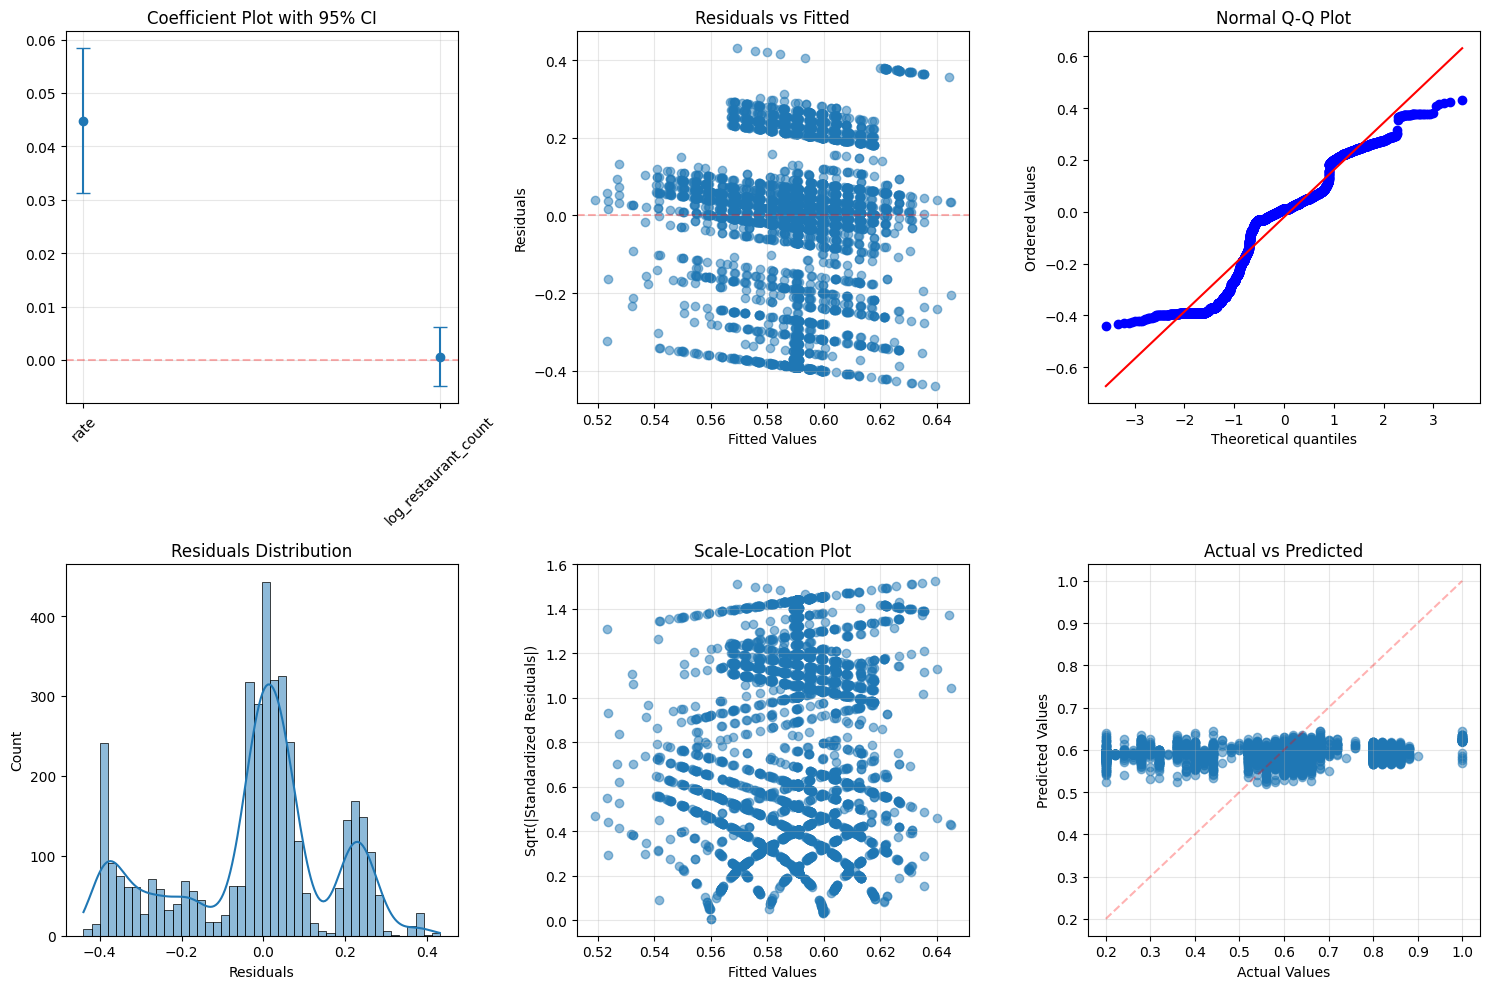

In [74]:
plot_regression_results(robust_results, X1, y1)

In [75]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [76]:
d4.columns

NameError: name 'd4' is not defined

In [113]:
d6.columns

Index(['Unnamed: 0', 'online_order', 'book_table', 'rate', 'votes',
       'rest_type', 'dish_liked', 'cuisines', 'approx_cost_for_one_people',
       'menu_item', 'listed_in(type)', 'listed_in(city)', 'original_index'],
      dtype='object')

In [132]:
temp4 = d4.copy()
temp6 = d6.copy()
temp4['rate_is_valid'] = 1
temp6['rate_is_valid'] = 0
temp6['rate'] = temp6['rate'].apply(lambda x: np.nan if x == 'NEW' else x)
temp6['rate'] = temp6['rate'].apply(lambda x: np.nan if x == '-' else x)

temp6['rate'] = temp6['rate'].str.replace('/5','').astype(float)
temp6.dropna(subset=['rate'], inplace=True)

temp = pd.concat([temp4, temp6], ignore_index=True)
temp.shape

(41516, 14)

In [133]:
temp['rate']

0        4.1
1        4.1
2        3.8
3        3.7
4        3.8
        ... 
41511    3.6
41512    3.5
41513    3.7
41514    3.6
41515    3.4
Name: rate, Length: 41516, dtype: float64

In [ ]:
temp['rate'] = temp['rate'].apply(lambda x: float(x.split('/')[0]) if type(x) == str else x)

In [140]:
from scipy.stats import f_oneway

# one way anova
group1 = temp[temp['rate_is_valid'] == 1]['rate']
group2 = temp[temp['rate_is_valid'] == 0]['rate']

f_oneway(group1, group2)

F_onewayResult(statistic=np.float64(11589.223191556133), pvalue=np.float64(0.0))

<Axes: xlabel='rate', ylabel='Density'>

<Axes: xlabel='rate', ylabel='Density'>

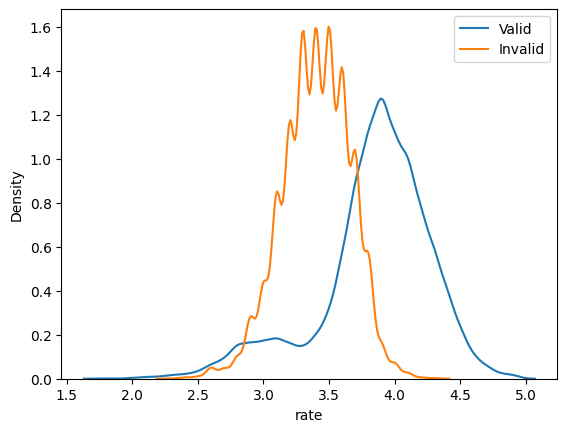

In [138]:
sns.kdeplot(group1, label='Valid')
sns.kdeplot(group2, label='Invalid')
plt.legend()
plt.show()